In [1]:
import numpy as np

from scipy.io import loadmat
from scipy import optimize

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import NonUniformImage
from matplotlib import cm

# 1 Logistic Regression (One vs. All Classification)

## 1.1 Data Visualisation

In [2]:
pathToDataFile = 'ex3data1.mat'
data = loadmat(pathToDataFile)
print("X", data['X'].shape)
print("y", data['y'].shape)

X (5000, 400)
y (5000, 1)


In [3]:
np.random.seed(0)
def digitDatum(x):
    '''converts vector x (1,400) into a matrix(32,32)'''
#     by default order='C', but in this case the lines are assembled in wrong order
    return np.reshape(x, (-1, 20), order='F')

def showRandomDigit(sampleSize):
    fig = plt.figure(figsize=(2, 2))
    digit = digitDatum(data['X'][np.random.randint(sampleSize)])
    plt.imshow(digit, cmap = 'gist_gray')
    plt.axis('off')
    return plt.show()

def showHundredDigits(visualisationSet):
    fig = plt.figure(figsize=(6, 6))
    for row in range(10):
        for column in range(10):
            digit = digitDatum(visualisationSet[10*row+column])
            sub = plt.subplot(10, 10, 10*row+column+1)
            sub.axis('off')
            sub.imshow(digit, cmap = 'gist_gray')
    return plt.show()

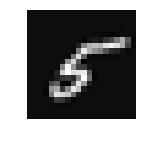

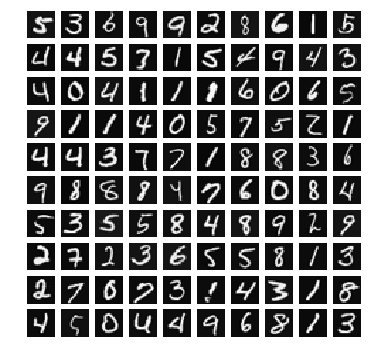

In [4]:
sampleSize, numVariables = data['X'].shape
showRandomDigit(sampleSize)
randIndex = np.random.randint(5000, size = 100)
visualisationSet = data['X'][randIndex,:]
showHundredDigits(visualisationSet)


## 1.2 Data Extraction and Transformation

In [5]:
def getData(pathToDataFile):
    data = loadmat(pathToDataFile)
    X = np.insert(data['X'], 0, 1, axis=1)
    y = data['y']
    sampleSize, numVariables = X.shape
    beta = np.zeros(numVariables)
    return beta, X, y

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def hypothesis(beta, X):
#     h(5000x1) = X(5000x401)*beta(401x1)
    return sigmoid(np.dot(X, beta[:, None]))

def costFunction(beta, X, y, iLambda = 0.):
    sampleSize, numVariables = X.shape  # X(5000x401)
#     hypothesis vector h(5000x1) = X(5000x401)*beta(401x1)
    h = hypothesis(beta, X)
#     cost function scalar J (1x1) = y.T(1x5000)*h(5000x1)
    J = (- np.dot(y.T, np.log(h)) - np.dot((1-y).T, np.log(1-h)))/sampleSize
#     regularisation scalar (R)
    R = iLambda*np.dot(beta[1:].T,beta[1:])/(2*sampleSize)
#     return (cost.item(0))
    return (J + R)[0,0]

def gradient(beta, X, y, iLambda=0.):
    sampleSize, numVariables = X.shape
#     hypothesis (h)
    h = hypothesis(beta, X)
#     error vector e(5000x1) = h(5000x1) - y(5000x1)
    e = h - y
#     gradient vector g(401x1) = e.T(1x5000)*X(401x5000)
    g = np.dot(X.T,e)/(sampleSize)
#     regularisation term vector (r(400x1)) — derivative of the regularisation term of the cost funtion
    r = beta[1:, None]*(iLambda/sampleSize)
    g[1:] = g[1:] + r
    return g.flatten()

In [7]:
pathToWeightsDataFile = 'ex3weights.mat'
weights = loadmat(pathToWeightsDataFile)
weights['Theta1'].shape

(25, 401)

In [8]:
beta, X, y = getData(pathToDataFile)
print(hypothesis(beta, X))
print(beta[:, None].shape)
print(beta.shape)
print(gradient(beta, X, y, iLambda=0.).shape)
print(costFunction(beta, X, y, iLambda = 0.))

[[ 0.5]
 [ 0.5]
 [ 0.5]
 ..., 
 [ 0.5]
 [ 0.5]
 [ 0.5]]
(401, 1)
(401,)
(401,)
160.394257582


In [9]:
def betaOptimisation(beta, X, y, iLambda=0.):
    betaArray = {}
    for i in np.unique(data['y']):
        
        optimisedBeta = optimize.minimize(costFunction, beta, args=(X, y == i, iLambda), method=None,
                                          jac=gradient, options={'maxiter':50})
        betaArray[i] = optimisedBeta['x']

#         optimisedBeta = optimize.fmin_cg(costFunction, fprime=gradient, x0=beta, args=(X, y == i, iLambda),
#                                          maxiter=50, disp=False, full_output=True)
#         betaArray[i] = optimisedBeta[0]
    return(betaArray)

In [10]:
def ONEvsALL_classifier(beta, x, yOptions):
    assignmentScore = {} 
    for i in yOptions:
        assignmentScore[i] = hypothesis(optimisedBeta[i], x)
    assignment = max(assignmentScore, key=assignmentScore.get)
    return assignment

In [11]:
beta, X, y = getData(pathToDataFile)
optimisedBeta = betaOptimisation(beta, X, y, iLambda=0.)
yOptions = np.unique(data['y'])
sampleSize, numVariables = X.shape

yAssignmentVector = []
misAssignedIndex = []
for iRow in range(sampleSize):
    x = X[iRow]
    yAssignment =  ONEvsALL_classifier(beta, x, yOptions)
    if yAssignment == y[iRow]:
        yAssignmentVector += [True]
    else:
        yAssignmentVector += [False]
        misAssignedIndex += [iRow]
print (sum(yAssignmentVector)/5000)

0.9332


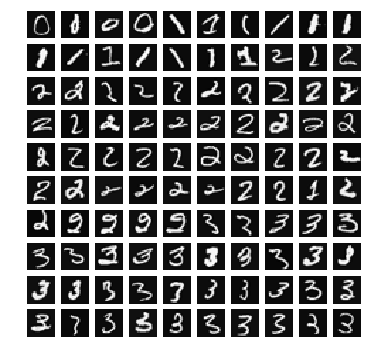

In [12]:
misAssignedSet = data['X'][misAssignedIndex,:]
showHundredDigits(misAssignedSet)

https://stackoverflow.com/questions/40531646/scipy-optimize-function-matrixes-not-aligned

https://stackoverflow.com/questions/28735344/pythonvalueerror-shapes-3-and-118-1-not-aligned-3-dim-0-118-dim-0

https://stackoverflow.com/questions/25880634/logistic-regression-objects-are-not-aligned

# 2 Neural Network (Forward Propagation)

In [13]:
pathToWeightsFile = 'ex3weights.mat'
weights = loadmat(pathToWeightsFile)
print(weights['Theta1'].shape)
print(weights['Theta2'].shape)

(25, 401)
(10, 26)


In [14]:
def getData_NN(pathToDataFile):
    data = loadmat(pathToDataFile)
    X = data['X']
    y = data['y']
    return X, y

def sigmoid(z):
    return 1/(1+np.exp(-z))

def forwardPropagation(betaSet, X):
    a = X
    for beta in betaSet:
        z = np.dot(np.insert(a, 0, 1, axis=1), beta.T)
        a = sigmoid(z)
    return a


In [15]:
X, y = getData_NN(pathToDataFile)
betaSet = (weights['Theta1'], weights['Theta2'])
print(X.shape)
output = forwardPropagation(betaSet, X)
print (output.shape)
print (y.shape)
print ((output - y).shape)
yAssignment_NN = np.argmax(output, axis=-1) + 1
print (yAssignment_NN)
print (y.flatten())
print (np.sum(yAssignment_NN == y.flatten())/5000)

(5000, 400)
(5000, 10)
(5000, 1)
(5000, 10)
[10 10 10 ...,  9  9  9]
[10 10 10 ...,  9  9  9]
0.9752


In [16]:
1 - (np.array([np.arange(1,11),]* 5000) == y)

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ..., 
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 1]])

In [17]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [18]:
0.5 - (np.array([np.unique(y)]* y.shape[0]) == y)

array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5],
       ..., 
       [ 0.5,  0.5,  0.5, ...,  0.5, -0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5, -0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5, -0.5,  0.5]])

http://cs229.stanford.edu/notes/cs229-notes1.pdf